In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score
%matplotlib inline

2024-05-22 13:08:56.918935: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 13:08:56.988901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 13:08:57.982795: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 13:08:57.984251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 13:09:10.533562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
# The 3 regressors are separately trained nn models. See Microphysics document for a walkthrough
scratch_dir = "/glade/derecho/scratch/wchuang/mlmicrophysics/"
work_dir = "/glade/work/wchuang/mlmicrophysics/"
run_label = "tau_run_11_"
run_date = "20240320_callbacks_retrain"
nrtendfolder = "20240521_add_CLD_lev_FREQR"
print("Reading files")
# Quantile inputs
test_quant_inputs_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_quant_input_test.parquet")
test_quant_inputs_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_quant_input_test.parquet")
test_quant_inputs_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/mp_quant_input_test.parquet")

print("Reading file ", scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_quant_output_test.parquet")
# Quantile outputs
quant_output_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_quant_output_test.parquet")
quant_output_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_quant_output_test.parquet")
quant_output_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/mp_quant_output_test.parquet")
# test_quant_output = pd.concat([quant_output_qctend, quant_output_nctend, quant_output_nrtend], axis=1)

# Outputs
output_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_output_test.parquet")
output_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_output_test.parquet")
output_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/mp_output_test.parquet")

# Meta tests
meta_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_meta_test.parquet")
meta_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_meta_test.parquet")
meta_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/mp_meta_test.parquet")

# Load neural network
nn_em_qctend = load_model(work_dir + run_label + "qctend" + "/" + run_date + "/quantile_neural_net_keras.h5")
nn_em_nctend = load_model(work_dir + run_label + "nctend" + "/" + run_date + "/quantile_neural_net_keras.h5")
nn_em_nrtend = load_model("/glade/work/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/model.h5")

In [5]:
# test_inputs = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_10/optimized/mp_quant_input_test.parquet")
# test_quant_outputs = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_10/optimized/mp_quant_output_test.parquet")
# test_outputs = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_10/optimized/mp_output_test.parquet")
# test_meta = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_10/optimized/mp_meta_test.parquet")

In [6]:
# output quantile transformer
with open("/glade/work/wchuang/mlmicrophysics/tau_run_11_nrtend/20240320_callbacks_retrain/output_quantile_transform.pkl", "rb") as out_quant_transform_file:
    output_scaler = pickle.load(out_quant_transform_file)
# input quantile transformer
with open("/glade/work/wchuang/mlmicrophysics/tau_run_11_nrtend/20240320_callbacks_retrain/input_quantile_transform.pkl", "rb") as in_quant_transform_file:
    input_scaler = pickle.load(in_quant_transform_file)

# nrtend input
with open("/glade/work/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/input_quantile_transform.pkl", "rb") as in_quant_transform_file:
    input_scaler_nrtend = pickle.load(in_quant_transform_file)
with open("/glade/work/wchuang/mlmicrophysics/tau_run_12_nrtend/" + nrtendfolder + "/output_quantile_transform.pkl", "rb") as out_quant_transform_file:
    output_scaler_nrtend = pickle.load(out_quant_transform_file)

In [7]:
# with open("/glade/work/wchuang/mlmicrophysics/tau_run_11_nrtend/20240320_callbacks_retrain/output_quantile_transform.pkl", "rb") as out_quant_transform_file:
#     output_scaler_2 = pickle.load(out_quant_transform_file)
# # Input quantile transformer
# with open("/glade/work/wchuang/mlmicrophysics/tau_run_11_nrtend/20240320_callbacks_retrain/input_quantile_transform.pkl", "rb") as in_quant_transform_file:
#     input_scaler_2 = pickle.load(in_quant_transform_file)

In [ ]:
# plt.plot(input_scaler.references_, input_scaler.quantiles_,  marker='o')
# plt.gca().set_yscale("log")

In [ ]:
# # This should have the shape of ("number of quantile bins", "number of regressor variables")
# output_scaler.quantiles_.shape

In [ ]:
# type(output_scaler.quantiles_)

In [ ]:
# np.count_nonzero(test_output["qctend_TAU"] != 0) / test_output["qctend_TAU"].shape[0]

In [ ]:
# output_scaler

In [8]:
# DJ mentioned that the quantile transformed inputs should be the same regardless of which model I am running
# But here it is different! I only get good results if I am using the quant_inputs for the specific model I trained on
nn_qctend_preds_quant = nn_em_qctend.predict(test_quant_inputs_qctend, batch_size=64000)
nn_nctend_preds_quant = nn_em_nctend.predict(test_quant_inputs_nctend, batch_size=64000)
nn_nrtend_preds_quant = nn_em_nrtend.predict(test_quant_inputs_nrtend, batch_size=64000)

55/55 [==============================] - 31s 567ms/step


In [9]:
# test_quant_inputs_nrtend

,QC_TAU_in,QR_TAU_in,NC_TAU_in,NR_TAU_in,PGAM,LAMC,LAMR,N0R,RHO_CLUBB,CLOUD,FREQR,lev
0,0.691330,0.513514,0.598224,0.599652,0.381430,0.521766,0.539337,0.619933,0.013516,0.818879,0.0,0.0
1,0.124293,0.983302,0.055400,0.966337,0.902007,0.270626,0.604532,0.957770,0.009741,0.094128,0.0,0.0
2,0.751831,0.476311,0.869963,0.568772,0.134251,0.118850,0.566231,0.593079,0.009517,0.081777,0.0,0.0
3,0.794335,0.658755,0.741083,0.694764,0.259577,0.376617,0.371511,0.695937,0.009310,0.367915,0.0,0.0
4,0.780640,0.559137,0.731582,0.644414,0.250061,0.377565,0.525719,0.659894,0.014635,0.818879,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3510035,0.040894,0.000000,0.168148,0.000000,0.658559,0.942411,0.000000,0.000000,0.999897,1.000000,0.0,1.0
3510036,0.175326,0.027988,0.301236,0.033117,0.553877,0.891337,0.945311,0.037692,0.998519,0.818879,0.0,1.0
3510037,0.102342,0.035366,0.263741,0.038902,0.583623,0.937079,0.902286,0.043791,0.999440,0.625434,0.0,1.0
3510038,0.231364,0.162090,0.191835,0.247912,0.640006,0.743889,0.928622,0.296441,0.999802,0.818879,0.0,1.0


In [11]:
# nn_nrtend_preds_quant_nr

array([[0.50137283],
       [0.50137283],
       [0.50137283],
       ...,
       [0.50137283],
       [0.50137283],
       [0.50137283]])

In [12]:
# nn_qctend_preds_quant = nn_qctend_preds_quant.squeeze()
# nn_nctend_preds_quant = nn_nctend_preds_quant.squeeze()
# nn_nrtend_preds_quant = nn_nrtend_preds_quant.squeeze()

In [13]:
# nn_preds_quant = pd.DataFrame(zip(nn_qctend_preds_quant, nn_nctend_preds_quant, nn_nrtend_preds_quant), columns=["qctend_TAU", "nctend_TAU", "nrtend_TAU"])

In [14]:
# test_quant_inputs_qctend

,QC_TAU_in,QR_TAU_in,NC_TAU_in,NR_TAU_in,PGAM,LAMC,LAMR,N0R,RHO_CLUBB
0,0.513432,0.355286,0.995902,0.085372,0.000000,0.893621,0.038807,0.052816,0.000024
1,0.246321,0.963844,0.626379,0.862904,0.355703,0.879049,0.173445,0.824345,0.000047
2,0.845180,0.769477,0.555717,0.801265,0.416241,0.052574,0.546907,0.802727,0.000031
3,0.275309,0.311854,0.107537,0.079838,0.919900,0.323362,0.051045,0.053257,0.000025
4,0.802990,0.752632,0.993014,0.720027,0.000000,0.547741,0.259968,0.698545,0.002879
...,...,...,...,...,...,...,...,...,...
2641147,0.490437,0.122246,0.668808,0.101284,0.282100,0.596505,0.527170,0.098725,0.989355
2641148,0.561206,0.144781,0.869492,0.182407,0.000000,0.472953,0.782791,0.196652,0.986483
2641149,0.430620,0.049087,0.768345,0.047709,0.187795,0.559460,0.854836,0.053970,0.988774
2641150,0.089111,0.035617,0.087689,0.046120,0.727487,0.675824,1.000000,0.071655,0.999646


In [16]:
# nn_qctend_preds_quant

array([[0.78723555],
       [0.34358866],
       [0.13307784],
       ...,
       [0.94115421],
       [0.94273133],
       [0.93377402]])

In [17]:
# nn_qctend_preds = output_scaler.inverse_transform(nn_qctend_preds_quant.reshape((*nn_qctend_preds_quant.shape, 1)))
# nn_nctend_preds = output_scaler.inverse_transform(nn_nctend_preds_quant.reshape((*nn_nctend_preds_quant.shape, 1)))
# nn_nrtend_preds = output_scaler.inverse_transform(nn_nrtend_preds_quant.reshape((*nn_nrtend_preds_quant.shape, 1)))
nn_qctend_preds = output_scaler.inverse_transform(nn_qctend_preds_quant.reshape(-1, 1))
nn_nctend_preds = output_scaler.inverse_transform(nn_nctend_preds_quant.reshape(-1, 1))
nn_nrtend_preds = output_scaler_nrtend.inverse_transform(nn_nrtend_preds_quant.reshape(-1, 1))

/glade/u/home/wchuang/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [20]:
# updated_step_true = test_inputs_unscaled[:,:3] + test_outputs * 600

In [21]:
# np.count_nonzero(updated_step_true >= 0, axis=0) / updated_step.shape[0]

array([1.        , 0.0245014 , 0.94351058])

(array([6.000000e+00, 1.200000e+01, 1.390000e+02, 4.360000e+02,
        1.589000e+03, 1.982000e+03, 5.125000e+03, 8.047000e+03,
        7.589000e+03, 1.130900e+04, 7.354500e+04, 3.379300e+04,
        4.413300e+04, 4.990800e+04, 4.702700e+04, 6.974500e+04,
        1.054900e+05, 7.895100e+04, 1.123700e+05, 1.264550e+05,
        1.262600e+05, 1.408370e+05, 1.828350e+05, 2.039120e+05,
        1.938110e+05, 3.188320e+05, 7.831650e+05, 1.183695e+06,
        1.067209e+06, 8.625544e+06]),
 array([-1.49144063e+05, -1.44172609e+05, -1.39201156e+05, -1.34229703e+05,
        -1.29258250e+05, -1.24286797e+05, -1.19315344e+05, -1.14343890e+05,
        -1.09372437e+05, -1.04400984e+05, -9.94295309e+04, -9.44580778e+04,
        -8.94866246e+04, -8.45151714e+04, -7.95437182e+04, -7.45722651e+04,
        -6.96008119e+04, -6.46293587e+04, -5.96579055e+04, -5.46864524e+04,
        -4.97149992e+04, -4.47435460e+04, -3.97720928e+04, -3.48006397e+04,
        -2.98291865e+04, -2.48577333e+04, -1.98862801e+04,

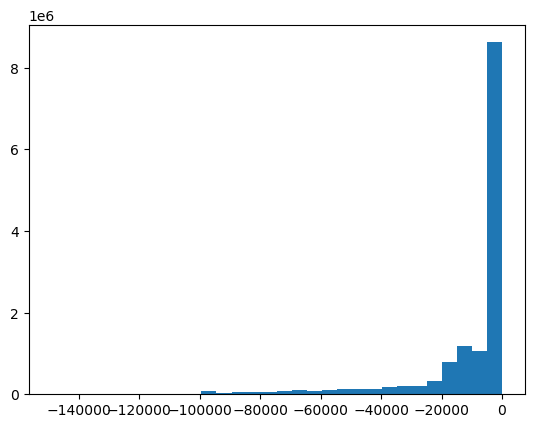

In [23]:
plt.hist(nn_preds[:, 0] + nn_preds[:, 1], bins=30)

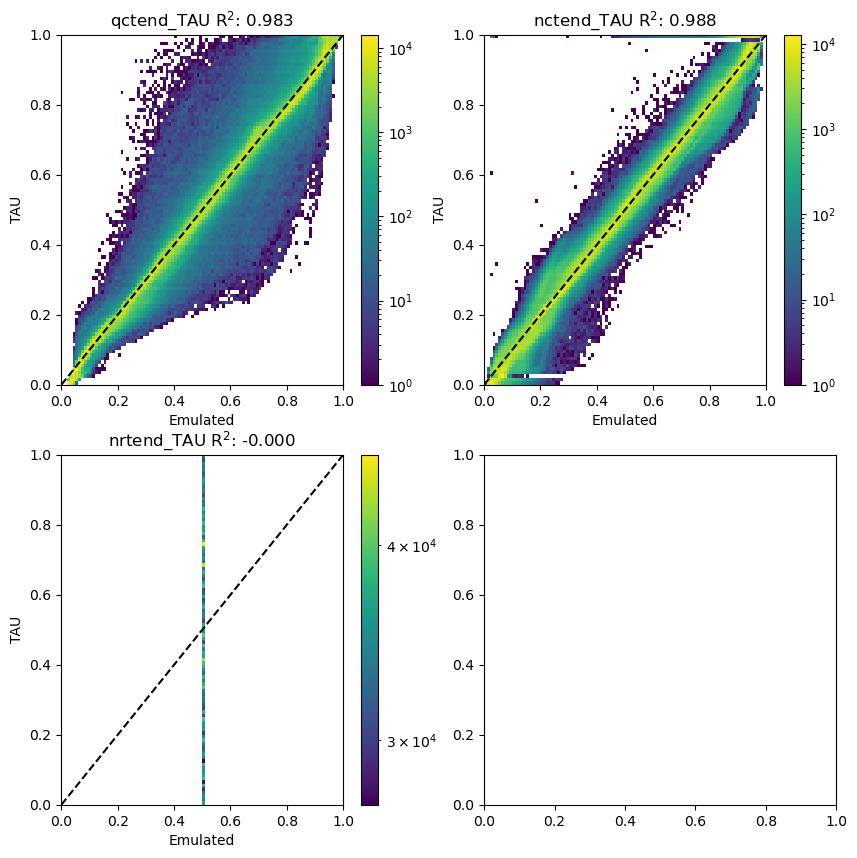

In [8]:
bins = np.arange(0, 1.01, 0.01)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
blah = axes[0, 0].hist2d(nn_qctend_preds_quant.squeeze(),
                         quant_output_qctend.squeeze(),
                         cmin=1, bins=bins, norm=LogNorm())
plt.colorbar(blah[-1], ax=axes[0,0])
axes[0, 0].set_xlabel("Emulated")
axes[0, 0].set_ylabel("TAU")
r2 = r2_score(quant_output_qctend.values, nn_qctend_preds_quant)
axes[0, 0].set_title("qctend_TAU" + f" R$^2$: {r2:0.3f}")
axes[0, 0].plot(bins, bins, 'k--')

blah = axes[0, 1].hist2d(nn_nctend_preds_quant.squeeze(),
                         quant_output_nctend.squeeze(),
                         cmin=1, bins=bins, norm=LogNorm())
plt.colorbar(blah[-1], ax=axes[0, 1])
axes[0, 1].set_xlabel("Emulated")
axes[0, 1].set_ylabel("TAU")
r2 = r2_score(quant_output_nctend.values, nn_nctend_preds_quant)
axes[0, 1].set_title("nctend_TAU" + f" R$^2$: {r2:0.3f}")
axes[0, 1].plot(bins, bins, 'k--')

blah = axes[1, 0].hist2d(nn_nrtend_preds_quant.squeeze(),
                         quant_output_nrtend.squeeze(),
                         cmin=1, bins=bins, norm=LogNorm())
plt.colorbar(blah[-1], ax=axes[1, 0])
axes[1, 0].set_xlabel("Emulated")
axes[1, 0].set_ylabel("TAU")
r2 = r2_score(quant_output_nrtend.values, nn_nrtend_preds_quant)
axes[1, 0].set_title("nrtend_TAU" + f" R$^2$: {r2:0.3f}")
axes[1, 0].plot(bins, bins, 'k--')
plt.savefig("tau_em_quant_hist2d_tau_run_11_" + nrtendfolder + ".png", dpi=300, bbox_inches="tight")

(array([8.000000e+00, 6.200000e+01, 4.250000e+02, 9.480000e+02,
        4.096500e+04, 1.359200e+04, 1.559700e+04, 3.066500e+04,
        2.291700e+04, 2.642400e+04, 2.314600e+04, 1.542800e+04,
        3.520000e+04, 3.352600e+04, 2.308000e+04, 3.392300e+04,
        4.423900e+04, 3.709200e+04, 5.069000e+04, 4.794200e+04,
        8.253000e+04, 8.644500e+04, 1.064230e+05, 6.156100e+04,
        7.368900e+04, 6.070500e+04, 7.457200e+04, 7.908900e+04,
        8.248700e+04, 1.093650e+05, 9.344200e+04, 1.247990e+05,
        1.216120e+05, 8.798400e+04, 1.247690e+05, 1.156440e+05,
        1.285170e+05, 1.604290e+05, 1.584010e+05, 1.763660e+05,
        2.904470e+05, 3.467760e+05, 6.000900e+05, 7.353220e+05,
        1.071767e+06, 9.702830e+05, 8.165620e+05, 8.609310e+05,
        1.204058e+06, 5.028965e+06]),
 array([-1.07864989e+05, -1.05708126e+05, -1.03551262e+05, -1.01394399e+05,
        -9.92375359e+04, -9.70806726e+04, -9.49238093e+04, -9.27669461e+04,
        -9.06100828e+04, -8.84532196e+04, 

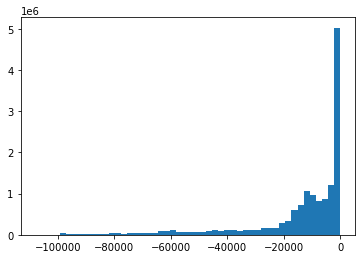

In [ ]:
# plt.hist(nn_preds[:, 2], bins=50)

<AxesSubplot:>

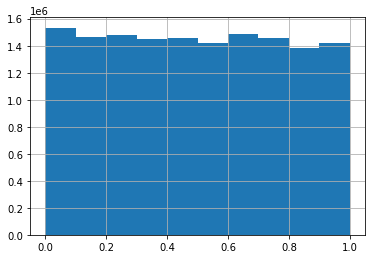

In [ ]:
# test_quant_outputs["nrtend_TAU"].hist()

<AxesSubplot:>

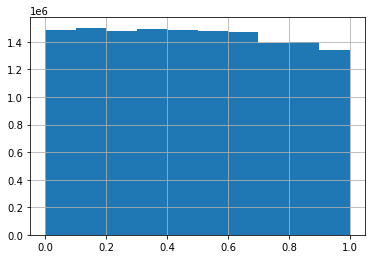

In [ ]:
# test_inputs["NC_TAU_in"].hist()

In [ ]:
# test_inputs["QR_TAU_in"] == 0

0            True
1           False
2           False
3           False
4           False
            ...  
14529894    False
14529895    False
14529896    False
14529897    False
14529898     True
Name: QR_TAU_in, Length: 14529899, dtype: bool

In [ ]:
# test_inputs.loc[2]

QC_TAU_in    0.047455
QR_TAU_in    0.170066
NC_TAU_in    0.508780
NR_TAU_in    0.229918
PGAM         0.401878
LAMC         0.991818
LAMR         0.852035
N0R          0.265155
Name: 2, dtype: float64

In [ ]:
# test_outputs.loc[2]

qctend_TAU   -5.687723e-13
qrtend_TAU    5.687723e-13
nctend_TAU   -1.438061e+01
nrtend_TAU   -3.038161e-03
Name: 2, dtype: float64

In [ ]:
# nn_preds[2]

array([-1.52318459e-11,  1.64325395e-11, -1.17031619e+03, -5.09551221e-03])

In [2]:
# The 3 regressors are separately trained nn models. See Microphysics document for a walkthrough
scratch_dir = "/glade/derecho/scratch/wchuang/mlmicrophysics/"
work_dir = "/glade/work/wchuang/mlmicrophysics/"
run_label = "tau_run_11_"
run_date = "20240320_callbacks_retrain"
nrtendfolder = "20240521_add_CLD_lev_FREQR"
print("Reading files")
# Quantile inputs
test_quant_inputs_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_quant_input_test.parquet")
test_quant_inputs_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_quant_input_test.parquet")
test_quant_inputs_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/mp_quant_input_test.parquet")

print("Reading file ", scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_quant_output_test.parquet")
# Quantile outputs
quant_output_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_quant_output_test.parquet")
quant_output_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_quant_output_test.parquet")
quant_output_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/mp_quant_output_test.parquet")
# test_quant_output = pd.concat([quant_output_qctend, quant_output_nctend, quant_output_nrtend], axis=1)

# Outputs
output_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_output_test.parquet")
output_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_output_test.parquet")
output_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/mp_output_test.parquet")

# Meta tests
meta_qctend = pd.read_parquet(scratch_dir + run_label + "qctend" + "/" + run_date + "/mp_meta_test.parquet")
meta_nctend = pd.read_parquet(scratch_dir + run_label + "nctend" + "/" + run_date + "/mp_meta_test.parquet")
meta_nrtend = pd.read_parquet("/glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/mp_meta_test.parquet")

# Load neural network
nn_em_qctend = load_model(work_dir + run_label + "qctend" + "/" + run_date + "/quantile_neural_net_keras.h5")
nn_em_nctend = load_model(work_dir + run_label + "nctend" + "/" + run_date + "/quantile_neural_net_keras.h5")
nn_em_nrtend = load_model("/glade/work/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/model.h5")

# output quantile transformer
with open("/glade/work/wchuang/mlmicrophysics/tau_run_11_nrtend/20240320_callbacks_retrain/output_quantile_transform.pkl", "rb") as out_quant_transform_file:
    output_scaler = pickle.load(out_quant_transform_file)
# input quantile transformer
with open("/glade/work/wchuang/mlmicrophysics/tau_run_11_nrtend/20240320_callbacks_retrain/input_quantile_transform.pkl", "rb") as in_quant_transform_file:
    input_scaler = pickle.load(in_quant_transform_file)

# nrtend input
with open("/glade/work/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/input_quantile_transform.pkl", "rb") as in_quant_transform_file:
    input_scaler_nrtend = pickle.load(in_quant_transform_file)
with open("/glade/work/wchuang/mlmicrophysics/tau_run_12_nr/" + nrtendfolder + "/output_quantile_transform.pkl", "rb") as out_quant_transform_file:
    output_scaler_nrtend = pickle.load(out_quant_transform_file)

Reading files
Reading file  /glade/derecho/scratch/wchuang/mlmicrophysics/tau_run_11_qctend/20240320_callbacks_retrain/mp_quant_output_test.parquet


2024-05-22 13:09:42.537720: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
nn_qctend_preds_quant = nn_em_qctend.predict(test_quant_inputs_qctend, batch_size=64000)
nn_nctend_preds_quant = nn_em_nctend.predict(test_quant_inputs_nctend, batch_size=64000)
nn_nrtend_preds_quant = nn_em_nrtend.predict(test_quant_inputs_nrtend, batch_size=64000)

55/55 [==============================] - 10s 176ms/step


In [5]:
nn_qctend_preds = output_scaler.inverse_transform(nn_qctend_preds_quant.reshape(-1, 1))
nn_nctend_preds = output_scaler.inverse_transform(nn_nctend_preds_quant.reshape(-1, 1))
nn_nrtend_preds = output_scaler_nrtend.inverse_transform(nn_nrtend_preds_quant.reshape(-1, 1))

/glade/u/home/wchuang/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


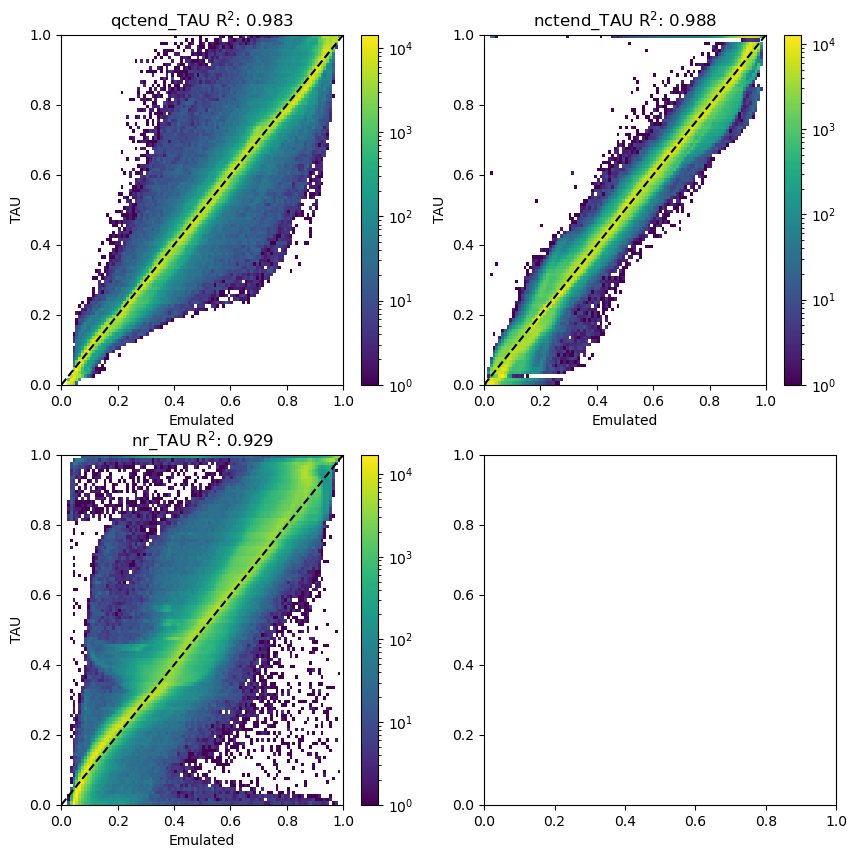

In [7]:
bins = np.arange(0, 1.01, 0.01)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
blah = axes[0, 0].hist2d(nn_qctend_preds_quant.squeeze(),
                         quant_output_qctend.squeeze(),
                         cmin=1, bins=bins, norm=LogNorm())
plt.colorbar(blah[-1], ax=axes[0,0])
axes[0, 0].set_xlabel("Emulated")
axes[0, 0].set_ylabel("TAU")
r2 = r2_score(quant_output_qctend.values, nn_qctend_preds_quant)
axes[0, 0].set_title("qctend_TAU" + f" R$^2$: {r2:0.3f}")
axes[0, 0].plot(bins, bins, 'k--')

blah = axes[0, 1].hist2d(nn_nctend_preds_quant.squeeze(),
                         quant_output_nctend.squeeze(),
                         cmin=1, bins=bins, norm=LogNorm())
plt.colorbar(blah[-1], ax=axes[0, 1])
axes[0, 1].set_xlabel("Emulated")
axes[0, 1].set_ylabel("TAU")
r2 = r2_score(quant_output_nctend.values, nn_nctend_preds_quant)
axes[0, 1].set_title("nctend_TAU" + f" R$^2$: {r2:0.3f}")
axes[0, 1].plot(bins, bins, 'k--')

blah = axes[1, 0].hist2d(nn_nrtend_preds_quant.squeeze(),
                         quant_output_nrtend.squeeze(),
                         cmin=1, bins=bins, norm=LogNorm())
plt.colorbar(blah[-1], ax=axes[1, 0])
axes[1, 0].set_xlabel("Emulated")
axes[1, 0].set_ylabel("TAU")
r2 = r2_score(quant_output_nrtend.values, nn_nrtend_preds_quant)
axes[1, 0].set_title("nr_TAU" + f" R$^2$: {r2:0.3f}")
axes[1, 0].plot(bins, bins, 'k--')
# plt.savefig("tau_em_quant_hist2d_tau_run_12_nr" + nrtendfolder + ".png", dpi=300, bbox_inches="tight")